# Working with Superphot+

Superphot+ was designed to rapidly fit photometric SN-like light curves to an empirical model for subsequent classification or analysis.
This tutorial briefly covers how to import light curves directly from ALeRCE or ANTARES, apply pre-processing for improved quality, and run various sampling methods to fit the light curves.

## Data Importing and Preprocessing

Superphot+ is built on SNAPI (LINK), which provides functionality for easy importing and pre-processing of photometric data from various alert brokers. Here, we use SNAPI to import a ZTF light curve from ALeRCE.

In [1]:
from dustmaps.config import config

config["data_dir"] = "."  # ensure dustmaps path is correct

# from superphot_plus.file_utils import read_single_lightcurve, save_single_lightcurve
from snapi.query_agents import ALeRCEQueryAgent, TNSQueryAgent
from snapi import Photometry, Transient

In [2]:
test_sn = "2022abfi"

alerce_agent = ALeRCEQueryAgent()
tns_agent = TNSQueryAgent()
transient = Transient(iid=test_sn)
qr_tns, success = tns_agent.query_transient(transient, local=True) # we dont want spectra
for result in qr_tns:
    transient.ingest_query_info(result.to_dict())
qr_alerce, success = alerce_agent.query_transient(transient)
for result in qr_alerce:
    transient.ingest_query_info(result.to_dict())


    tid          time               candid  fid           pid  diffmaglim  \
1   ztf  59902.280069  2148280062115015013    1  2.148280e+12   20.216372   
2   ztf  59904.178796  2150178792115015047    1  2.150179e+12   20.618118   
5   ztf  59906.199965  2152199962115015019    1  2.152200e+12   20.751240   
6   ztf  59908.238495  2154238492115015017    1  2.154238e+12   20.428700   
8   ztf  59910.214583  2156214582115015024    1  2.156215e+12   20.686329   
11  ztf  59922.238981  2168238982115015011    1  2.168239e+12   19.536272   
14  ztf  59928.200428  2174200422115015022    1  2.174200e+12   20.235287   
15  ztf  59932.129618  2178129612115015021    1  2.178130e+12   20.774820   
17  ztf  59934.199630  2180199622115015025    1  2.180200e+12   20.326313   
20  ztf  59874.216088                  NaN    1           NaN   20.752300   
22  ztf  59877.286551                  NaN    1           NaN   20.743800   
24  ztf  59879.322928                  NaN    1           NaN   20.679900   

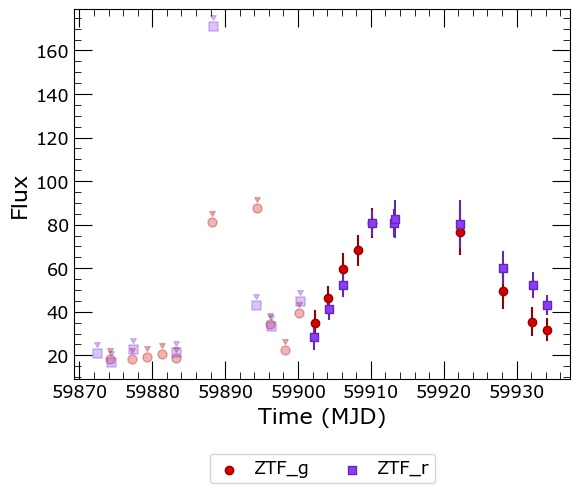

In [3]:
# plot imported LC
import matplotlib.pyplot as plt
from snapi import Formatter

photometry = transient.photometry
formatter = Formatter()
fig, ax = plt.subplots()

photometry.plot(ax, mags=False)
formatter.add_legend(ax)
formatter.make_plot_pretty(ax)
plt.show()

Here, the nondetections are marked as semi-transparent upper-limits, with the detections shown opaque wih uncertainty margins. Superphot+ currently only works with detections.

Let's phase the light curve and correct for extinction:

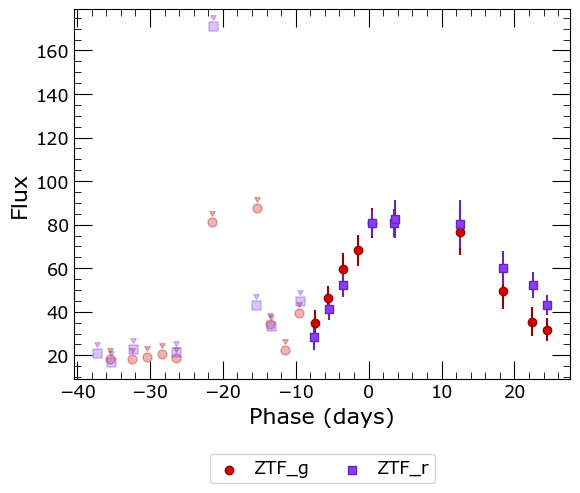

In [5]:
photometry.phase()
corr_lcs = []
for lc in photometry.light_curves:
    corr_lcs.append(
        lc.correct_extinction(coordinates=transient.coordinates)
    )
photometry = Photometry(corr_lcs)
transient.photometry = photometry

fig, ax = plt.subplots()

photometry.plot(ax, mags=False)
formatter.add_legend(ax)
formatter.make_plot_pretty(ax)
plt.show()


Now let's save this file for later use:

In [6]:
# all data will be saved in root directory "data" folder
import os
from pathlib import Path

p = Path(os.getcwd()).parents[1]
SAVE_DIR = os.path.join(p, "data")
print(SAVE_DIR)

/Users/kdesoto/python_repos/superphot-plus/data


In [7]:
transient.save(
    os.path.join(SAVE_DIR, test_sn+".h5")
)

For our numpyro samplers, we need to pad all bands to have the same number of points. To do this, we create a padded variant of our transient photometry:

/Users/kdesoto/python_repos/superphot-plus/data
                                flux   flux_unc        mag   mag_unc  \
time                                                                   
-36 days +12:29:13.505295  18.158501        NaN  20.530423       NaN   
-33 days +14:10:41.499833  18.301218        NaN  20.521923       NaN   
-31 days +15:03:04.498557  19.410646        NaN  20.458023       NaN   
-29 days +15:42:14.500777  20.802714        NaN  20.382823       NaN   
-27 days +13:04:03.503977  19.030053        NaN  20.479523       NaN   
-22 days +13:02:54.504955  81.425419        NaN  18.901223       NaN   
-16 days +15:45:56.505608  87.635486        NaN  18.821423       NaN   
-14 days +12:38:00.502074  34.220000        NaN  19.842423       NaN   
-12 days +12:34:17.503686  22.255636        NaN  20.309523       NaN   
-10 days +12:18:21.504969  39.297055        NaN  19.692223       NaN   
-8 days +14:01:21.498244   34.915897   5.993395  19.820565  0.186369   
-6 days +11:35:3

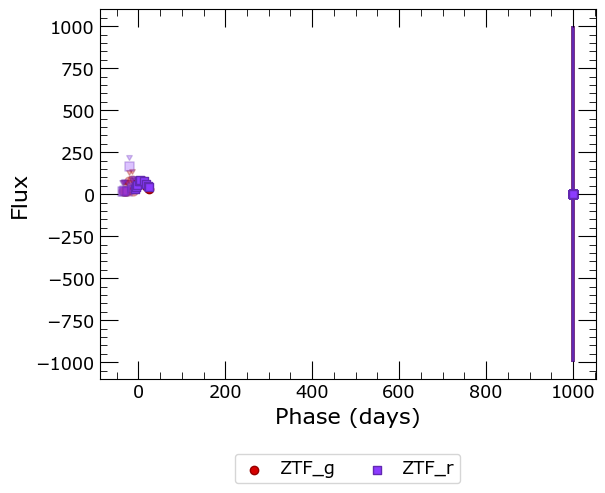

In [1]:
from astropy.time import Time
import astropy.units as u
from snapi import Transient, Formatter
import os
from pathlib import Path
import matplotlib.pyplot as plt
from snapi import Photometry

test_sn = "2022abfi"
p = Path(os.getcwd()).parents[1]
SAVE_DIR = os.path.join(p, "data")
print(SAVE_DIR)

transient = Transient.load(
    os.path.join(SAVE_DIR, test_sn+".h5"),
)

padded_lcs = set()
fill = {'time': 1000., 'flux': 0.1, 'flux_unc': 1000., 'zpt': 23.90, 'non_detections': False}

padded_lcs = []
for lc in transient.photometry.light_curves:
    padded_lc=lc.pad(fill, 32 - len(lc.detections))
    padded_lcs.append(padded_lc)

padded_photometry = Photometry(padded_lcs)
transient.photometry = padded_photometry
transient.save(
    os.path.join(SAVE_DIR, test_sn+"_padded.h5")
)
print(padded_photometry.detections)
formatter = Formatter()
fig, ax = plt.subplots()
padded_photometry.plot(ax, mags=False)
formatter.add_legend(ax)
formatter.make_plot_pretty(ax)
plt.show()


## Fitting Light Curves

There are a few sampling techniques implemented for rapid fitting of light curves:
* Nested sampling (`dynesty`) constrains the posterior space with nested ellipsoids of increasing density.
* Advanced HMC with the NUTS sampler (using `numpyro`) uses Hamiltonian Monte Carlo sampling but without U-turns to increase sampling efficiency.
* Stochastic variational inference (SVI; also using `numpyro`) approximates the marginal distributions for each fit as Gaussians, which sacrifices precision for much faster runtime. Recommended for realtime applications.

Let's use each to fit our test light curve:

In [1]:
from snapi import Transient
import os

from superphot_plus.samplers.dynesty_sampler import DynestySampler
from superphot_plus.samplers.numpyro_sampler import NUTSSampler, SVISampler
from superphot_plus.surveys.surveys import Survey

from pathlib import Path

p = Path(os.getcwd()).parents[1]
SAVE_DIR = os.path.join(p, "data")
test_sn = "2022abfi"
fn_to_fit = os.path.join(SAVE_DIR, test_sn + ".h5")
transient = Transient.load(fn_to_fit)
photometry = transient.photometry
priors = Survey.ZTF().priors

                                flux   flux_unc        mag   mag_unc  \
time                                                                   
-36 days +12:29:13.505295  18.158501        NaN  20.530423       NaN   
-33 days +14:10:41.499833  18.301218        NaN  20.521923       NaN   
-31 days +15:03:04.498557  19.410646        NaN  20.458023       NaN   
-29 days +15:42:14.500777  20.802714        NaN  20.382823       NaN   
-27 days +13:04:03.503977  19.030053        NaN  20.479523       NaN   
-22 days +13:02:54.504955  81.425419        NaN  18.901223       NaN   
-16 days +15:45:56.505608  87.635486        NaN  18.821423       NaN   
-14 days +12:38:00.502074  34.220000        NaN  19.842423       NaN   
-12 days +12:34:17.503686  22.255636        NaN  20.309523       NaN   
-10 days +12:18:21.504969  39.297055        NaN  19.692223       NaN   
-8 days +14:01:21.498244   34.915897   5.993395  19.820565  0.186369   
-6 days +11:35:31.502413   46.142466   5.606675  19.517871  0.13

In [ ]:
%%time

import traceback
import warnings
import sys

def warn_with_traceback(message, category, filename, lineno, file=None, line=None):

    log = file if hasattr(file,'write') else sys.stderr
    traceback.print_stack(file=log)
    log.write(warnings.formatwarning(message, category, filename, lineno, line))

warnings.showwarning = warn_with_traceback

sampler = DynestySampler(
    priors=priors,
    random_state=42
)
sampler.fit_photometry(photometry)
sampler.result.save(
    save_prefix=test_sn+"_result",
    save_folder=SAVE_DIR
)
print("Nested sampling")
print(sampler.result.fit_parameters.head())

In [5]:
%%time

# use padded photometry
padded_fn = os.path.join(SAVE_DIR, test_sn + "_padded.h5")
pad_transient = Transient.load(padded_fn)
pad_photometry = pad_transient.photometry

sampler = NUTSSampler(
    priors=priors,
    pad_size=32,
    num_chains=1,
    random_state=42
)
sampler.fit_photometry(pad_photometry)
sampler.result.save(
    save_prefix=test_sn+"_result",
    save_folder=SAVE_DIR
)
print("NUTS")
print(sampler.result.fit_parameters.head())

                                flux     flux_unc        mag       mag_unc  \
time                                                                         
-36 days +12:29:13.505295  18.158501          NaN  20.530423           NaN   
-33 days +14:10:41.499833  18.301218          NaN  20.521923           NaN   
-31 days +15:03:04.498557  19.410646          NaN  20.458023           NaN   
-29 days +15:42:14.500777  20.802714          NaN  20.382823           NaN   
-27 days +13:04:03.503977  19.030053          NaN  20.479523           NaN   
-22 days +13:02:54.504955  81.425419          NaN  18.901223           NaN   
-16 days +15:45:56.505608  87.635486          NaN  18.821423           NaN   
-14 days +12:38:00.502074  34.220000          NaN  19.842423           NaN   
-12 days +12:34:17.503686  22.255636          NaN  20.309523           NaN   
-10 days +12:18:21.504969  39.297055          NaN  19.692223           NaN   
-8 days +14:01:21.498244   34.915897     5.993395  19.820565    

sample: 100%|██████████| 20000/20000 [00:29<00:00, 678.32it/s, 73 steps of size 4.27e-02. acc. prob=0.90] 


NUTS
      log_A      beta  log_gamma        t0  log_tau_rise  log_tau_fall  \
0  0.078595  0.011527   1.170375 -5.407145      0.432000      1.515461   
1  0.076455  0.011575   1.210804 -5.223138      0.421528      1.534401   
2  0.067259  0.010337   1.116588 -4.794470      0.516148      1.555434   
3  0.065786  0.010360   1.118566 -4.790077      0.524796      1.567884   
4  0.065849  0.009699   1.121311 -4.889987      0.529978      1.492749   

   log_extra_sigma  log_A_ZTF_g  beta_ZTF_g  log_gamma_ZTF_g  t0_ZTF_g  \
0        -1.756765    -0.076556    0.000841        -0.277542 -1.378336   
1        -1.827019    -0.069111    0.001090        -0.270145 -1.399951   
2        -2.108563    -0.074245    0.002014        -0.229360 -1.267300   
3        -2.118670    -0.074696    0.002017        -0.230386 -1.305299   
4        -2.115592    -0.086452   -0.001347        -0.152114 -1.180234   

   log_tau_rise_ZTF_g  log_tau_fall_ZTF_g  log_extra_sigma_ZTF_g  
0           -0.178620           -0.197

In [7]:
%%time

# use padded photometry
padded_fn = os.path.join(SAVE_DIR, test_sn + "_padded.h5")
pad_transient = Transient.load(padded_fn)
pad_photometry = pad_transient.photometry

sampler = SVISampler(
    priors=priors,
    num_iter=10_000,
    random_state=42,
    pad_size=32
)
sampler.fit_photometry(pad_photometry)
sampler.result.save(
    save_prefix=test_sn+"_result",
    save_folder=SAVE_DIR
)
print("SVI")
print(sampler.result.fit_parameters.head())

                                flux     flux_unc        mag       mag_unc  \
time                                                                         
-36 days +12:29:13.505295  18.158501          NaN  20.530423           NaN   
-33 days +14:10:41.499833  18.301218          NaN  20.521923           NaN   
-31 days +15:03:04.498557  19.410646          NaN  20.458023           NaN   
-29 days +15:42:14.500777  20.802714          NaN  20.382823           NaN   
-27 days +13:04:03.503977  19.030053          NaN  20.479523           NaN   
-22 days +13:02:54.504955  81.425419          NaN  18.901223           NaN   
-16 days +15:45:56.505608  87.635486          NaN  18.821423           NaN   
-14 days +12:38:00.502074  34.220000          NaN  19.842423           NaN   
-12 days +12:34:17.503686  22.255636          NaN  20.309523           NaN   
-10 days +12:18:21.504969  39.297055          NaN  19.692223           NaN   
-8 days +14:01:21.498244   34.915897     5.993395  19.820565    

Now, let's plot each fit to compare results!

/Users/kdesoto/python_repos/superphot-plus/src/superphot_plus/samplers/numpyro_sampler.py:388: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  self._mcmc = MCMC(


0.6740583337262512
0.16482301
0.18245834


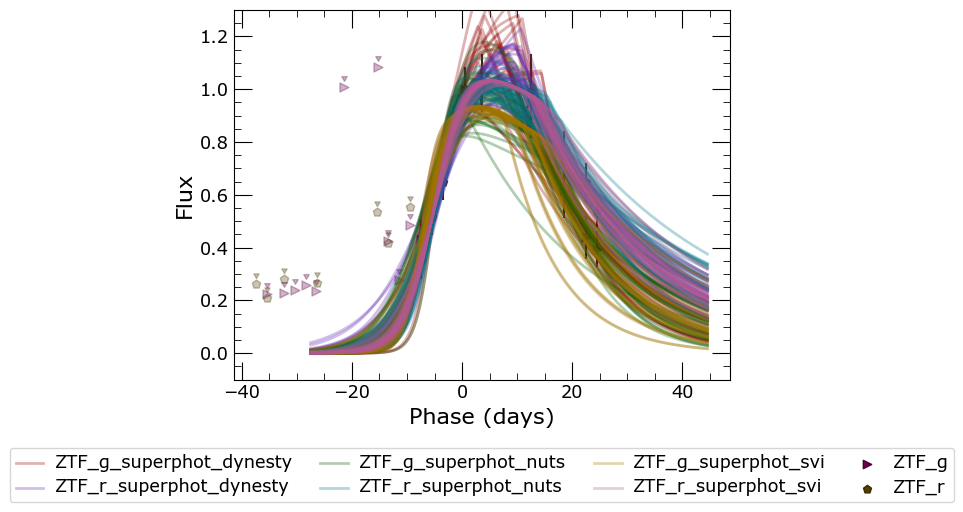

In [8]:
from superphot_plus.samplers import *
from snapi import Formatter
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
formatter = Formatter()
dsampler = DynestySampler(priors=priors)
nsampler = NUTSSampler(priors=priors, pad_size=32)
ssampler = SVISampler(priors=priors, pad_size=32)
for sampler in [dsampler, nsampler, ssampler]:
    sampler.load_result(
        load_prefix=test_sn+"_result",
        load_folder=SAVE_DIR
    )
    print(sampler.result.score)
    ax = sampler.plot_fit(
        ax, formatter,
        photometry,
    )
photometry.plot(ax, formatter, mags=False)
ax.set_ylim((-0.1, 1.3))
formatter.add_legend(ax)
formatter.make_plot_pretty(ax)
plt.show()


It looks like there is a tradeoff between fit time and fit quality, though there may be an issues with priors. Plotting the distribution for our differing parameters ($t0$ and $\gamma$), we get:

In [ ]:
from superphot_plus.file_utils import get_posterior_samples

params_dynesty = get_posterior_samples(
    test_sn, fits_dir=OUTPUT_DIR, sampler='dynesty'
)[0]
params_NUTS = get_posterior_samples(
    test_sn, fits_dir=OUTPUT_DIR, sampler='NUTS'
)[0]
params_svi = get_posterior_samples(
    test_sn, fits_dir=OUTPUT_DIR, sampler='svi'
)[0]
print(params_dynesty[0])

t0_idx = 3
gamma_idx = 2

plt.hist(params_dynesty[:, t0_idx], alpha=0.5, label="dynesty", density=True)
plt.hist(params_NUTS[:, t0_idx], alpha=0.5, label="NUTS", density=True)
plt.hist(params_svi[:, t0_idx], alpha=0.5, label="SVI", density=True)
plt.xlabel("t0")
plt.legend()
plt.show()

In [ ]:
from superphot_plus.surveys.surveys import Survey

ztf_priors = Survey.ZTF().priors
r_priors = ztf_priors.bands["r"]
PRIOR_GAMMA = r_priors.gamma

plt.hist(params_dynesty[:, gamma_idx], alpha=0.5, label="dynesty", density=True)
plt.hist(params_NUTS[:, gamma_idx], alpha=0.5, label="NUTS", density=True)
plt.hist(params_svi[:, gamma_idx], alpha=0.5, label="SVI", density=True)
plt.axvline(PRIOR_GAMMA.mean, c="r", label="Prior")
plt.axvline(PRIOR_GAMMA.mean + PRIOR_GAMMA.std, c="r", linestyle="dashed")
plt.axvline(PRIOR_GAMMA.mean - PRIOR_GAMMA.std, c="r", linestyle="dashed")
plt.xlabel("log gamma")
plt.xlim((0.5, 2))
plt.legend()
plt.show()

## Classification

Superphot+ uses the resulting fit parameters as input features for a multi-layer perceptron (MLP) classifier. We can call the classification functions to return probabilities of the object being each of 5 major supernova types:

In [8]:
import os
import numpy as np
from superphot_plus.trainer import SuperphotTrainer
from superphot_plus.file_utils import get_posterior_samples

test_sn = "ZTF22abvdwik" 
OUTPUT_DIR = "../examples/outputs/"
TRAINED_MODEL_FN = os.path.join(OUTPUT_DIR, "model.pt")
TRAINED_CONFIG_FN = os.path.join(OUTPUT_DIR, "model.yaml")

trainer = SuperphotTrainer(
    TRAINED_CONFIG_FN,
    OUTPUT_DIR,
    sampler="dynesty",
    model_type='MLP',
    probs_file=None,
    n_folds=1,
)
trainer.setup_model(load_checkpoint=True)
lc_probs = trainer.classify_single_light_curve(
    test_sn, OUTPUT_DIR, sampler="dynesty"
)
# Alternatively, classify from posterior samples directly
fit_params = get_posterior_samples(test_sn, OUTPUT_DIR, "dynesty")[0]
adj_params = np.delete(fit_params, [0,3], axis=1)
lc_probs2 = trainer.models[0].classify_from_fit_params(adj_params)
print(np.subtract(lc_probs, np.mean(lc_probs2, axis=0)))

../examples/outputs
[ 0.01131504  0.34618992 -0.15608865 -0.39089653  0.18947991]
